In [64]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:.6f}'.format

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score

from statsmodels.tsa.stattools import coint

# !pip install kneed

from kneed import KneeLocator

In [33]:
# importing the excel file that we have already pre cleaned

full_df = pd.read_excel('Data/crypto_dataset.xlsx')

full_df['Date'] = pd.to_datetime(full_df['Date'])
full_df.set_index('Date', inplace=True)

In [40]:
# computing the cumulative returns

cumret = np.log(full_df).diff().cumsum()+1 # calculate cumulative returns
cumret.dropna(inplace=True)

<AxesSubplot:xlabel='Date'>

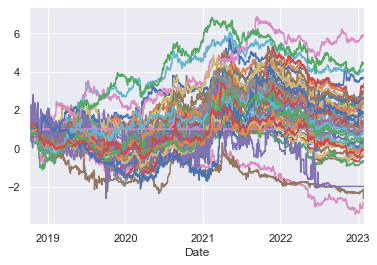

In [41]:
cumret.plot(legend=False)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:title={'center':'Plot of returns vs. volatility'}, xlabel='return', ylabel='std'>

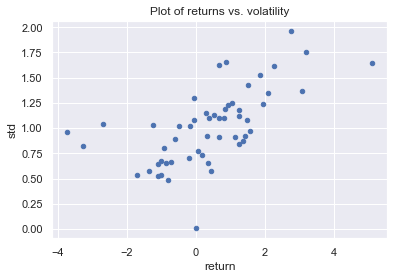

In [53]:
dict_to_cluster = {}

for col in list(cumret.columns.values):
    dict_to_cluster[col] = {
        "return": cumret[col].iloc[-1] - cumret[col].iloc[0],
        # "return": cumret[col].diff().mean(),
        "std": cumret[col].std()
    }
    
df_to_cluster = pd.DataFrame.from_dict(dict_to_cluster, orient='index')
df_to_cluster.plot.scatter(x='return', y='std', title='Plot of returns vs. volatility')

In [139]:
# copy variable

X = df_to_cluster

## Performing Clustering on the train set

- Let's first use K-means algo to find the different clusters

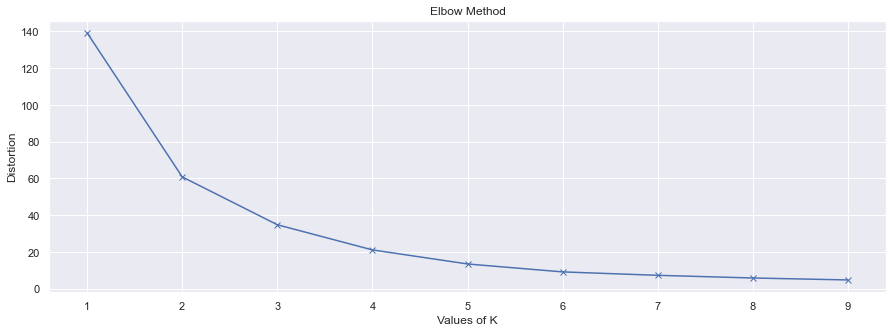

Optimal number of cluster is: 3, according to knee plot


In [116]:
# elbow plot to find optimal nmb of clusters

K = range(1,10)
distortions = []

#Fit the method
for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

#Plot the results
fig = plt.figure(figsize= (15,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

# use KneeLocator from K need to find optimal number

kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
print(f'Optimal number of cluster is: {kl.elbow}, according to knee plot')

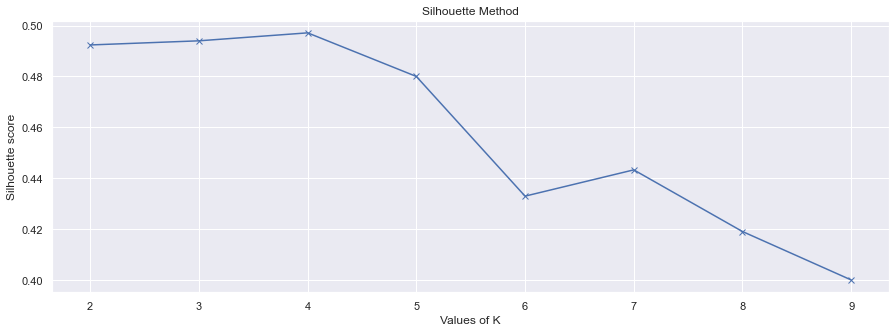

Suggested number of clusters:  2


In [117]:
# For the silhouette method k needs to start from 2

K = range(2,10)
silhouettes = []

#Fit the method
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init='random')
    kmeans.fit(X)
    silhouettes.append(silhouette_score(X, kmeans.labels_))

    
#Plot the results
fig = plt.figure(figsize= (15,5))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method')
plt.grid(True)
plt.show()

kl = KneeLocator(K, silhouettes, curve="convex", direction="decreasing")
print('Suggested number of clusters: ', kl.elbow)

/var/folders/lb/6zbgqrg520b7c61dgy_1b_tw0000gn/T/ipykernel_95024/180003948.py:21: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scatter)


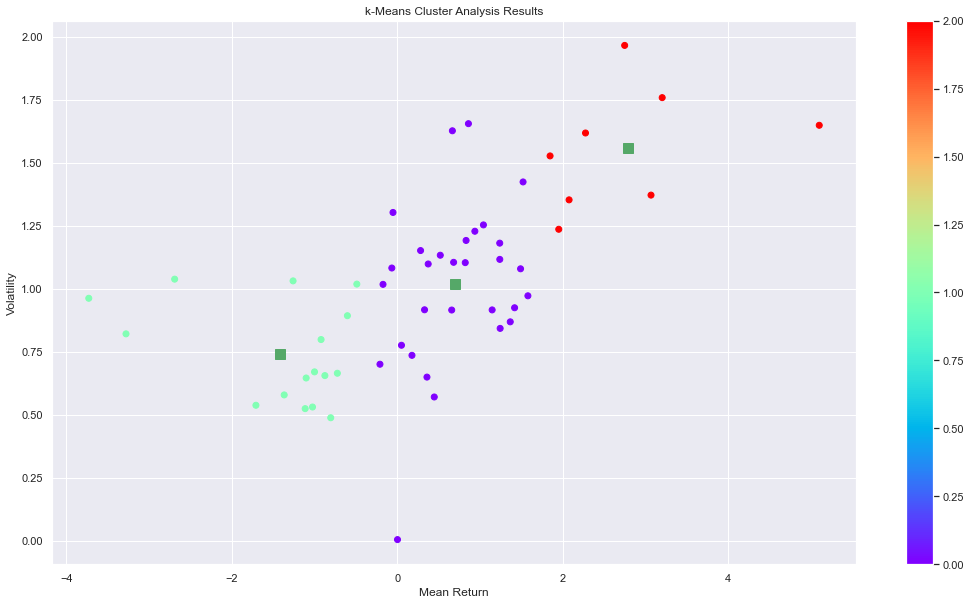

In [126]:
# we use 3 as the number of optimal cluster as it also works on the first plot

c = 3


#Fit the model

k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(X)


#Plot the results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize = (18,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c=k_means.labels_, cmap="rainbow", label = X.index)
ax.set_title('k-Means Cluster Analysis Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=10)
plt.show()

In [132]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = df_to_cluster.index.values
cluster_map['cluster'] = k_means.labels_

# cluster_map.set_index('data_index', inplace=True)
cluster_map.head()

,data_index,cluster
0,ADA-USD,0
1,AVT-USD,0
2,BAT-USD,0
3,BCH-USD,1
4,BLZ-USD,1


<AxesSubplot:xlabel='Date'>

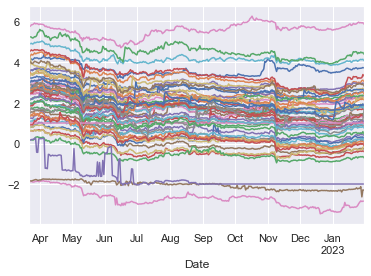

In [143]:
# test train split of cumret

split = int(np.count_nonzero(cumret.index.values) * 0.8)

train_cumret = cumret.copy().iloc[:split] # formation period
test_cumret = cumret.copy().iloc[split+1:] # trading period

test_cumret.plot(legend=False)

### Cointegration test



In [162]:
# input the selected cluster

get_sub_cluster = 1


# create the train test split

df_train = train_cumret.copy()[list(cluster_map[cluster_map.cluster == get_sub_cluster]["data_index"])]
df_test = test_cumret.copy()[list(cluster_map[cluster_map.cluster == get_sub_cluster]["data_index"])]

print(f'Cluster nmb {get_sub_cluster} is composed of: {df_train.columns.values}')

Cluster nmb 1 is composed of: ['BCH-USD' 'BLZ-USD' 'BNT-USD' 'DASH-USD' 'EOS-USD' 'GTC-USD' 'LOOM-USD'
 'MIR-USD' 'OMG-USD' 'QSP-USD' 'REP-USD' 'SUPER-USD' 'XLM-USD' 'ZEC-USD'
 'ZEN-USD' 'ZRX-USD']


In [158]:
train = df_train.copy()
tested = []
metrics_obj = {}

for s1 in train.columns:
    for s2 in train.columns:
        if s1!=s2 and (f'{s1}-{s2}' not in tested) and (f'{s2}-{s1}' not in tested):
                tested.append(f'{s1}-{s2}')
                cadf_p = coint(train[s1], train[s2])[1]
                spread_window = 25
                spread = np.log10(train[s1] / train[s1].shift(periods=spread_window)) - np.log10(train[s2] / train[s2].shift(periods=spread_window))
                spread = spread.fillna(0)
                std_spread = spread.std()
                correlation = train[s1].corr(train[s2])
                metrics_obj[f'{s1}-{s2}'] = {
                    "co-int": cadf_p,
                    "std_spread": std_spread,
                    "correlation": correlation
                }


/Users/alex/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/alex/opt/anaconda3/lib/python3.9/site-packages/pandas

In [163]:
pd.options.display.float_format = '{:.6f}'.format
df_metrics = pd.DataFrame.from_dict(metrics_obj, orient='index')
df_metrics["rating"] = (1 - df_metrics["co-int"]) + df_metrics["correlation"] + 10*df_metrics["std_spread"]
df_metrics.sort_values(by="rating", ascending=False).iloc[:30]

,co-int,std_spread,correlation,rating
DASH-USD-LOOM-USD,0.004509,0.475064,0.854582,6.600715
DASH-USD-SUPER-USD,0.046230,0.508196,0.439601,6.475334
DASH-USD-ZEN-USD,0.032407,0.450540,0.813776,6.286768
DASH-USD-XLM-USD,0.014923,0.440490,0.866214,6.256193
LOOM-USD-ZEN-USD,0.343567,0.471404,0.757373,6.127846
BCH-USD-XLM-USD,0.143663,0.448838,0.770335,6.115053
DASH-USD-OMG-USD,0.068465,0.439704,0.765209,6.093780
SUPER-USD-ZEN-USD,0.004869,0.473850,0.318886,6.052518
BCH-USD-SUPER-USD,0.163862,0.492629,0.289421,6.051845
BCH-USD-LOOM-USD,0.294853,0.467865,0.640283,6.024082


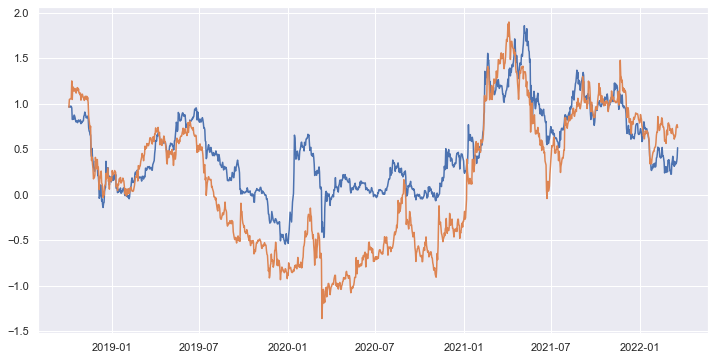

In [180]:
x1 = df_train['DASH-USD']
x2 = df_train['LOOM-USD']


plt.figure(figsize=(12,6))
plt.plot(x1)
plt.plot(x2)